## Example #1: Load in a model and plot sea ice concentration maps

#### Hint: use Shift+return to run each notebook "cell"

In [1]:
# First load in modules that we need

# This makes plots appear in line here in the notebook
%matplotlib inline 

# Basic python modules we need
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import xarray as xr
import glob
import datetime

# Spatial plotting package
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# Seaborn had nice color palettes
import seaborn as sns
np.seterr(divide='ignore', invalid='ignore')

from esio import EsioData as ed
from esio import import_data
from esio import ice_plot
from esio import metrics
from esio import download

# General plotting settings
sns.set_style('whitegrid')
sns.set_context("talk", font_scale=.8, rc={"lines.linewidth": 2.5})

# Step 1: Load in some data

#### SIPN2 data is currently stored here:
/home/disk/sipn/nicway/data/

You can poke around here and see what obs (observations) and model (models) we have.
For now, lets load in the NRL forecasts.

In [2]:
# Define data dir
data_dir = '/home/disk/sipn/nicway/data/model/usnavyncep/forecast/sipn_nc'

In [3]:
# See what is there. These are all netcdf files, grouped by date of initialization. 
!ls /home/disk/sipn/nicway/data/model/usnavyncep/forecast/sipn_nc

ARCu0_2018042112_Stereo.nc  ARCu0_2018052112_Stereo.nc
ARCu0_2018050512_Stereo.nc  ARCu0_2018052212_Stereo.nc
ARCu0_2018050612_Stereo.nc  ARCu0_2018052612_Stereo.nc
ARCu0_2018050712_Stereo.nc  ARCu0_2018052712_Stereo.nc
ARCu0_2018050812_Stereo.nc  ARCu0_2018052812_Stereo.nc
ARCu0_2018051212_Stereo.nc  ARCu0_2018052912_Stereo.nc
ARCu0_2018051312_Stereo.nc  ARCu0_2018060212_Stereo.nc
ARCu0_2018051412_Stereo.nc  ARCu0_2018060312_Stereo.nc
ARCu0_2018051512_Stereo.nc  ARCu0_2018060412_Stereo.nc
ARCu0_2018051912_Stereo.nc  ARCu0_2018060512_Stereo.nc
ARCu0_2018052012_Stereo.nc


In [4]:
# We can peak inside with ncdump
!ncdump -h /home/disk/sipn/nicway/data/model/usnavyncep/forecast/sipn_nc/ARCu0_2018042112_Stereo.nc

netcdf ARCu0_2018042112_Stereo {
dimensions:
	nj = 304 ;
	ni = 448 ;
	init_time = 1 ;
	fore_time = 45 ;
	ensemble = 1 ;
variables:
	double lon(nj, ni) ;
		lon:_FillValue = NaN ;
	double lat(nj, ni) ;
		lat:_FillValue = NaN ;
	int64 init_time(init_time) ;
		init_time:units = "days since 2018-04-21 12:00:00" ;
		init_time:calendar = "proleptic_gregorian" ;
	int64 fore_time(fore_time) ;
		fore_time:units = "hours" ;
	double sic(init_time, ensemble, fore_time, nj, ni) ;
		sic:_FillValue = NaN ;
		sic:regrid_method = "nearest_s2d" ;
		sic:coordinates = "lon lat" ;
	double hi(init_time, ensemble, fore_time, nj, ni) ;
		hi:_FillValue = NaN ;
		hi:regrid_method = "nearest_s2d" ;
		hi:coordinates = "lon lat" ;
	double uvel(init_time, ensemble, fore_time, nj, ni) ;
		uvel:_FillValue = NaN ;
		uvel:regrid_method = "nearest_s2d" ;
		uvel:coordinates = "lon lat" ;
	double vvel(init_time, ensemble, fore_time, nj, ni) ;
		vvel:_FillValue = NaN ;
		vvel:regrid_method = "nearest_s2d" ;
		vvel:coordinat

In [5]:
test_file = '/home/disk/sipn/nicway/data/model/usnavyncep/forecast/sipn_nc/ARCu0_2018042112_Stereo.nc'

In [6]:
# Use xarray (xr) to load the file into python
ds_model = xr.open_mfdataset(test_file, chunks={'fore_time': 1, 'init_time': 1,  
                              'nj': 304, 'ni': 448}, 
                              concat_dim='init_time')
ds_model.rename({'nj':'x', 'ni':'y'}, inplace=True)

<xarray.Dataset>
Dimensions:    (ensemble: 1, fore_time: 45, init_time: 1, x: 304, y: 448)
Coordinates:
    lon        (x, y) float64 168.3 168.4 168.5 168.7 168.8 168.9 169.0 ...
    lat        (x, y) float64 31.1 31.25 31.4 31.55 31.69 31.84 31.99 32.13 ...
  * fore_time  (fore_time) timedelta64[ns] 0 days 12:00:00 1 days 12:00:00 ...
  * init_time  (init_time) datetime64[ns] 2018-04-21T12:00:00
Dimensions without coordinates: ensemble, x, y
Data variables:
    sic        (init_time, ensemble, fore_time, x, y) float64 dask.array<shape=(1, 1, 45, 304, 448), chunksize=(1, 1, 1, 304, 448)>
    hi         (init_time, ensemble, fore_time, x, y) float64 dask.array<shape=(1, 1, 45, 304, 448), chunksize=(1, 1, 1, 304, 448)>
    uvel       (init_time, ensemble, fore_time, x, y) float64 dask.array<shape=(1, 1, 45, 304, 448), chunksize=(1, 1, 1, 304, 448)>
    vvel       (init_time, ensemble, fore_time, x, y) float64 dask.array<shape=(1, 1, 45, 304, 448), chunksize=(1, 1, 1, 304, 448)>

In [7]:
# This shows us the same info as ncdump:
ds_model

<xarray.Dataset>
Dimensions:    (ensemble: 1, fore_time: 45, init_time: 1, x: 304, y: 448)
Coordinates:
    lon        (x, y) float64 168.3 168.4 168.5 168.7 168.8 168.9 169.0 ...
    lat        (x, y) float64 31.1 31.25 31.4 31.55 31.69 31.84 31.99 32.13 ...
  * fore_time  (fore_time) timedelta64[ns] 0 days 12:00:00 1 days 12:00:00 ...
  * init_time  (init_time) datetime64[ns] 2018-04-21T12:00:00
Dimensions without coordinates: ensemble, x, y
Data variables:
    sic        (init_time, ensemble, fore_time, x, y) float64 dask.array<shape=(1, 1, 45, 304, 448), chunksize=(1, 1, 1, 304, 448)>
    hi         (init_time, ensemble, fore_time, x, y) float64 dask.array<shape=(1, 1, 45, 304, 448), chunksize=(1, 1, 1, 304, 448)>
    uvel       (init_time, ensemble, fore_time, x, y) float64 dask.array<shape=(1, 1, 45, 304, 448), chunksize=(1, 1, 1, 304, 448)>
    vvel       (init_time, ensemble, fore_time, x, y) float64 dask.array<shape=(1, 1, 45, 304, 448), chunksize=(1, 1, 1, 304, 448)>

In [8]:
ds_model.dims
# That the file has 4 dimensions:
# ensemble (only 1)
# fore_time (the forecast time change from initialization)
# init_time (the time of initialization)
# x (index of spatial dimension x)
# y (index of spatial dimension y)

Frozen(SortedKeysDict(OrderedDict([('ensemble', 1), ('fore_time', 45), ('init_time', 1), ('y', 448), ('x', 304)])))

In [9]:
# Variables
ds_model.data_vars

Data variables:
    sic      (init_time, ensemble, fore_time, x, y) float64 dask.array<shape=(1, 1, 45, 304, 448), chunksize=(1, 1, 1, 304, 448)>
    hi       (init_time, ensemble, fore_time, x, y) float64 dask.array<shape=(1, 1, 45, 304, 448), chunksize=(1, 1, 1, 304, 448)>
    uvel     (init_time, ensemble, fore_time, x, y) float64 dask.array<shape=(1, 1, 45, 304, 448), chunksize=(1, 1, 1, 304, 448)>
    vvel     (init_time, ensemble, fore_time, x, y) float64 dask.array<shape=(1, 1, 45, 304, 448), chunksize=(1, 1, 1, 304, 448)>

In [10]:
ds_model.sic # Sea ice concentration

<xarray.DataArray 'sic' (init_time: 1, ensemble: 1, fore_time: 45, x: 304, y: 448)>
dask.array<shape=(1, 1, 45, 304, 448), dtype=float64, chunksize=(1, 1, 1, 304, 448)>
Coordinates:
    lon        (x, y) float64 168.3 168.4 168.5 168.7 168.8 168.9 169.0 ...
    lat        (x, y) float64 31.1 31.25 31.4 31.55 31.69 31.84 31.99 32.13 ...
  * fore_time  (fore_time) timedelta64[ns] 0 days 12:00:00 1 days 12:00:00 ...
  * init_time  (init_time) datetime64[ns] 2018-04-21T12:00:00
Dimensions without coordinates: ensemble, x, y
Attributes:
    regrid_method:  nearest_s2d

In [11]:
# We want to plot one time slice so grab the first init_time and forecast time
da_sic = ds_model.sic.isel(init_time=0).isel(ensemble=0).isel(fore_time=0)
da_sic

<xarray.DataArray 'sic' (x: 304, y: 448)>
dask.array<shape=(304, 448), dtype=float64, chunksize=(304, 448)>
Coordinates:
    lon        (x, y) float64 168.3 168.4 168.5 168.7 168.8 168.9 169.0 ...
    lat        (x, y) float64 31.1 31.25 31.4 31.55 31.69 31.84 31.99 32.13 ...
    fore_time  timedelta64[ns] 12:00:00
    init_time  datetime64[ns] 2018-04-21T12:00:00
Dimensions without coordinates: x, y
Attributes:
    regrid_method:  nearest_s2d

#### OK, lets plot something

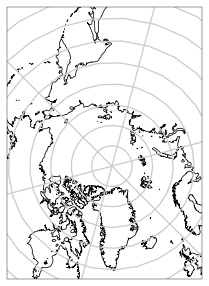

In [12]:
# First call our esio module to set up a polar map
(f, axes) = ice_plot.polar_axis()

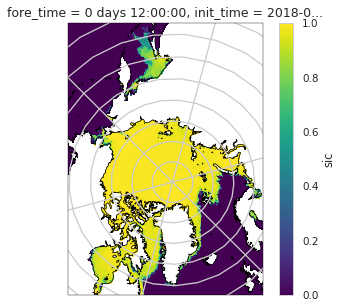

In [13]:
# Then add sea ice concentration to it
(f, ax1) = ice_plot.polar_axis()
da_sic.plot.pcolormesh(ax=ax1, x='lon', y='lat', 
                      transform=ccrs.PlateCarree(),
                      add_colorbar=True)

Text(0.5,1,'Sea Ice Concentration')

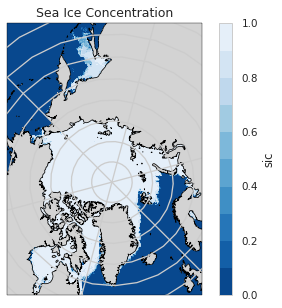

In [14]:
# Make it nicer by giving a colorbar
cmap_c = matplotlib.colors.ListedColormap(sns.color_palette("Blues_r", 10))
cmap_c.set_bad(color = 'lightgrey')
c_label = 'Sea Ice Concentration (-)'
c_vmin = 0
c_vmax = 1

# Then add sea ice concentration to it
(f, ax1) = ice_plot.polar_axis()
da_sic.plot.pcolormesh(ax=ax1, x='lon', y='lat', 
                      transform=ccrs.PlateCarree(),
                      add_colorbar=True,
                      cmap=cmap_c,
                      vmin=c_vmin, vmax=c_vmax)
ax1.set_title('Sea Ice Concentration')

## An example of how these functions are used for the [operational map plots](https://atmos.washington.edu/~nicway/sipn/modelforecasts.html) can be found [here](https://github.com/NicWayand/ESIO/blob/master/notebooks/plot_all_model_maps.ipynb)